<a href="https://colab.research.google.com/github/arsalanmubeen/IBA/blob/main/Maria_Baloch_variational_AE_Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Autoencoder using fraud gaurd usecase

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.manifold import TSNE
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.naive_bayes import GaussianNB

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

## uploading data set from kaggle using json key


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 91% 60.0M/66.0M [00:00<00:00, 85.8MB/s]
100% 66.0M/66.0M [00:00<00:00, 120MB/s] 


In [ ]:
data = pd.read_csv('/content/creditcardfraud.zip') # Reading the file .csv
df = pd.DataFrame(data) # Converting data to Panda DataFrame
df2=df

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Visualization


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


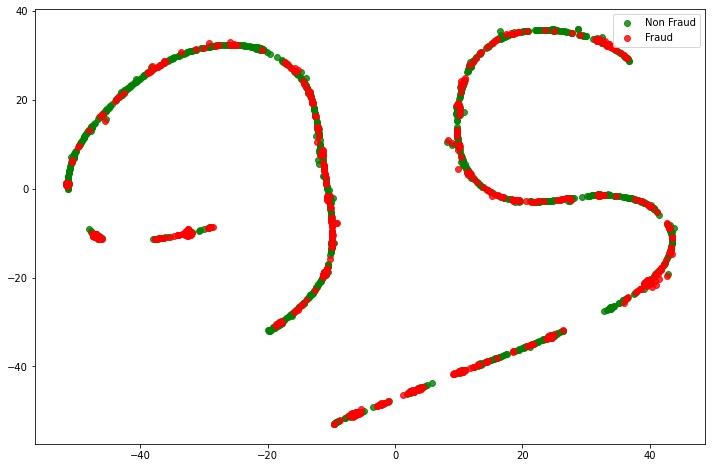

In [ ]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

## 3. Training Variational AE


In [ ]:
X1_train, X1_test  = train_test_split(df2, test_size=0.25)

In [ ]:
data['Amount'].skew()

16.977724453761024

In [ ]:
X1_train.loc[:,"Time"] = X1_train["Time"].apply(lambda x : x / 3600 % 24)#transform the Time field to time-of-day to account 
X1_train.loc[:,'Amount'] = np.log(X1_train['Amount']+1) #The Amount field is transformed to log scale deal with

X1_test.loc[:,"Time"] = X1_test["Time"].apply(lambda x : x / 3600 % 24)
X1_test.loc[:,'Amount'] = np.log(X1_test['Amount']+1)
# data = data.drop(['Amount'], axis = 1)
print(X1_train.shape)
X1_train.head()

(213605, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
88074,17.214444,1.255338,0.297746,0.289835,0.701212,-0.441173,-1.091734,0.034491,-0.159910,0.149718,-0.260015,-0.198006,-0.176820,-0.548506,-0.133330,1.178926,0.514826,0.039057,-0.204199,-0.193311,-0.129985,-0.296380,-0.893411,0.138500,0.324177,0.189797,0.096977,-0.028172,0.029195,1.091923,0
247072,18.623889,2.052077,-0.323129,-0.746390,0.128206,-0.125334,0.065730,-0.574376,0.096946,1.317527,-0.117496,-1.425086,-0.134698,-0.367627,0.123996,1.189455,0.538046,-0.844830,0.159705,0.024686,-0.227525,-0.195391,-0.499699,0.339906,-0.041519,-0.368281,-0.599870,0.026865,-0.033049,0.779325,0
162959,8.089722,1.663797,-2.634775,0.083681,-1.189605,-2.596690,-0.184000,-1.718403,0.022509,-0.408945,1.359379,-1.090227,-0.851018,0.485723,-0.912537,0.581678,0.142714,0.234917,0.660926,-0.743028,0.138457,0.239649,0.615690,0.035533,-0.013438,-0.658502,-0.116207,0.029971,0.022265,5.693732,0
179324,10.451389,-0.824678,-0.245822,1.705919,-1.758074,0.352363,1.846339,0.587929,0.293432,-1.062134,-0.282331,-0.854870,-0.475511,0.120867,-0.437978,0.782663,-1.834583,0.173888,-0.120724,-2.117852,-0.225672,-0.545184,-1.118055,0.185906,-0.653361,0.015407,0.065382,-0.136404,-0.158629,4.875121,0
28488,9.730556,-0.848931,1.070734,0.576849,0.088994,1.785358,-0.504440,0.847046,-0.014670,-0.787413,-1.434249,-0.437020,0.117404,1.254390,-1.739766,0.623999,0.630138,0.552628,0.364062,-1.210998,0.069122,0.039195,0.084528,-0.358017,-0.876990,0.404578,-0.405876,0.113907,0.143344,0.693147,0


In [ ]:
X1_train = X1_train[X1_train.Class == 0] # train the model on normal transactions
X1_train = X1_train.drop(['Class'], axis=1)

y1_test = X1_test['Class']
X1_test  = X1_test.drop(['Class'], axis=1) #drop the class column


#transform to ndarray
X1_train = X1_train.values
X1_test = X1_test.values
X1_train.shape

(213235, 30)

In [ ]:
#Build Model
#The first two layers are used for encoder, the last two go for the decoder.
#Use L1 regularization during training

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = X1_train.shape[1] #num of columns, 29
encoding_dim = 14
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-5

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, 
                activation="tanh", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
nb_epoch = 300
batch_size = 128
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error',optimizer='adam')


tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X1_train, X1_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X1_test, X1_test),
                          verbose=1)

Epoch 1/300
1666/1666 [==============================] - 8s 3ms/step - loss: 4.3616 - accuracy: 0.9336 - val_loss: 2.1833 - val_accuracy: 0.9632
Epoch 2/300
1666/1666 [==============================] - 7s 4ms/step - loss: 1.5167 - accuracy: 0.9696 - val_loss: 1.1795 - val_accuracy: 0.9709
Epoch 3/300
1666/1666 [==============================] - 6s 4ms/step - loss: 1.0256 - accuracy: 0.9740 - val_loss: 0.9858 - val_accuracy: 0.9734
Epoch 4/300
1666/1666 [==============================] - 5s 3ms/step - loss: 0.9185 - accuracy: 0.9756 - val_loss: 0.9277 - val_accuracy: 0.9749
Epoch 5/300
1666/1666 [==============================] - 4s 2ms/step - loss: 0.8696 - accuracy: 0.9772 - val_loss: 0.8693 - val_accuracy: 0.9780
Epoch 6/300
1666/1666 [==============================] - 4s 3ms/step - loss: 0.8256 - accuracy: 0.9792 - val_loss: 0.8478 - val_accuracy: 0.9796
Epoch 7/300
1666/1666 [==============================] - 5s 3ms/step - loss: 0.8106 - accuracy: 0.9804 - val_loss: 0.8370 - val_ac

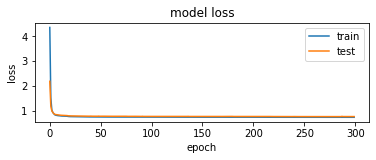

In [ ]:
# plot mse during training
plt.subplot(212)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
predictions = autoencoder.predict(X1_test)
mse = np.mean(np.power(X1_test - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse,'true_class': y1_test})
df_error.describe()

,reconstruction_error,true_class
count,71202.000000,71202.000000
mean,0.756827,0.001713
std,3.326876,0.041358
min,0.042019,0.000000
25%,0.259339,0.000000
50%,0.418117,0.000000
75%,0.654673,0.000000
max,391.771921,1.000000


In [ ]:
# Import modules
from sklearn.metrics import auc, roc_curve,precision_recall_curve
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import recall_score,f1_score,precision_recall_fscore_support

fpr_rf, tpr_rf, thresholds_rf  = roc_curve(df_error.true_class, df_error.reconstruction_error)
auc_rf  = auc(fpr_rf, tpr_rf)

# Plot the roc curve

#plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc)

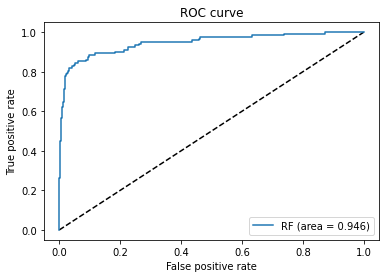

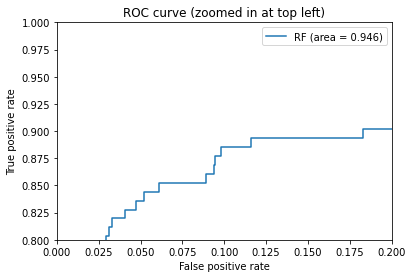

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()